# Checkpoint 1

Reminder: 

- You are being evaluated for completion and effort in this checkpoint. 
- Avoid manual labor / hard coding as much as possible, everything we've taught you so far are meant to simplify and automate your process.

We will be working with the same `states_edu.csv` that you should already be familiar with from the tutorial.

We investigated Grade 8 reading score in the tutorial. For this checkpoint, you are asked to investigate another test. Here's an overview:

* Choose a specific response variable to focus on
>Grade 4 Math, Grade 4 Reading, **Grade 8 Math**
* Pick or create features to use
>Will all the features be useful in predicting test score? Are some more important than others? Should you standardize, bin, or scale the data?
* Explore the data as it relates to that test
>Create at least 2 visualizations (graphs), each with a caption describing the graph and what it tells us about the data
* Create training and testing data
>Do you want to train on all the data? Only data from the last 10 years? Only Michigan data?
* Train a ML model to predict outcome 
>Define what you want to predict, and pick a model in sklearn to use (see sklearn <a href="https://scikit-learn.org/stable/modules/linear_model.html">regressors</a>).


Include comments throughout your code! Every cleanup and preprocessing task should be documented.

<h2> Data Cleanup </h2>

Import `numpy`, `pandas`, and `matplotlib`.

(Feel free to import other libraries!)

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Load in the "states_edu.csv" dataset and take a look at the head of the data

In [172]:
df: pd.DataFrame = pd.read_csv("../data/states_edu.csv")

You should always familiarize yourself with what each column in the dataframe represents. Read about the states_edu dataset here: https://www.kaggle.com/noriuk/us-education-datasets-unification-project

Use this space to rename columns, deal with missing data, etc. _(optional)_

<h2>Exploratory Data Analysis (EDA) </h2>

Chosen one of Grade 4 Reading, Grade 4 Math, or Grade 8 Math to focus on: ***Grade 8 Math***

In [173]:
RESULT_COLUMN: str = "AVG_MATH_8_SCORE"

How many years of data are logged in our dataset? 

In [174]:
num_years = df['YEAR'].nunique()
num_years

33

Let's compare Michigan to Ohio. Which state has the higher average across all years in the test you chose?

In [175]:
mi_df = df.loc[df["STATE"] == "MICHIGAN"]
oh_df = df.loc[df["STATE"] == "OHIO"]

avg_mi = mi_df[RESULT_COLUMN].mean()
avg_oh = oh_df[RESULT_COLUMN].mean()

print('MI' if avg_mi > avg_oh else 'OH', max(avg_mi, avg_oh))

OH 282.25


Find the average for your chosen test across all states in 2019

In [176]:
df_2019 = df.loc[df['YEAR'] == 2019]
avg_score_2019 = df_2019[RESULT_COLUMN].mean()
avg_score_2019

281.2641509433962

For each state, find a maximum value for your chosen test score

In [177]:
max_by_state = df.groupby('STATE')[RESULT_COLUMN].max()
max_by_state

STATE
ALABAMA                 269.0
ALASKA                  283.0
ARIZONA                 283.0
ARKANSAS                279.0
CALIFORNIA              277.0
COLORADO                292.0
CONNECTICUT             289.0
DELAWARE                284.0
DISTRICT_OF_COLUMBIA    269.0
DODEA                   293.0
FLORIDA                 281.0
GEORGIA                 281.0
HAWAII                  281.0
IDAHO                   287.0
ILLINOIS                285.0
INDIANA                 288.0
IOWA                    286.0
KANSAS                  290.0
KENTUCKY                282.0
LOUISIANA               273.0
MAINE                   289.0
MARYLAND                288.0
MASSACHUSETTS           301.0
MICHIGAN                280.0
MINNESOTA               295.0
MISSISSIPPI             274.0
MISSOURI                286.0
MONTANA                 293.0
NATIONAL                285.0
NEBRASKA                288.0
NEVADA                  278.0
NEW_HAMPSHIRE           296.0
NEW_JERSEY              296.0
NEW_

*Refer to the `Grouping and Aggregating` section in Tutorial 0 if you are stuck.

<h2> Feature Engineering </h2>

After exploring the data, you can choose to modify features that you would use to predict the performance of the students on your chosen response variable. 

You can also create your own features. For example, perhaps you figured that maybe a state's expenditure per student may affect their overall academic performance so you create a expenditure_per_student feature.

Use this space to modify or create features.

In [178]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    # Convert PRIMARY_KEY and STATE to categorical data types
    df['PRIMARY_KEY'] = df['PRIMARY_KEY'].astype('category')
    df['STATE'] = df['STATE'].astype('category')

    # Encode STATE column using LabelEncoder
    le = LabelEncoder()
    df['STATE'] = le.fit_transform(df['STATE'])

    # Rename variables for clarity
    df = df.rename({
    'GRADES_PK_G':'ENROLL_PREK',
    'GRADES_KG_G':'ENROLL_KINDER',
    'GRADES_4_G':'ENROLL_4',
    'GRADES_8_G':'ENROLL_8',
    'GRADES_12_G':'ENROLL_12',
    'GRADES_1_8_G':'ENROLL_PRIMARY',
    'GRADES_9_12_G':'ENROLL_HS',
    'GRADES_ALL_G':'ENROLL_ALL',
    'ENROLL':'ENROLL_ALL_EST',

    RESULT_COLUMN: 'target',
    },
    axis=1)

    return df

current_features: list[str]

def generate_features(df: pd.DataFrame, with_identifiers: bool=True, with_other_score: bool=True) -> tuple[pd.DataFrame, pd.DataFrame]:
    global current_features

    # Define base features
    features: list[str] = ['TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 
            'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 
            'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE', 'ENROLL_8', 'ENROLL_HS', 'ENROLL_ALL', 'ENROLL_ALL_EST']
    
    # Add optional features based on parameters
    if with_identifiers:
        features.extend(['YEAR', 'STATE'])
    if with_other_score:
        features.extend(['AVG_READING_8_SCORE'])
        
    financial_metrics: list[str] = ['TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', 
                            'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE',
                            'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']
    
    # Calculate financial ratios
    df = df.sort_values(['STATE', 'YEAR'])
    financial_denoms: list[str] = ['TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 
            'LOCAL_REVENUE', 'TOTAL_EXPENDITURE']
    
    for metric in financial_metrics:
        for denom in financial_denoms:
            relative_ratio = f'{metric}_{denom}_REL'
            df[relative_ratio] = df[metric] / df[denom]
            features.append(relative_ratio)
        
    # Calculate enrollment ratios
    df['GRADE_8_TO_HS_RATIO'] = df['ENROLL_8'] / df['ENROLL_HS']
    df['GRADE_8_TO_ALL_RATIO'] = df['ENROLL_8'] / df['ENROLL_ALL']
    features.extend(['GRADE_8_TO_HS_RATIO', 'GRADE_8_TO_ALL_RATIO'])

    # Calculate per-student metrics
    per_student_metrics = ['TOTAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE']
    for metric in per_student_metrics:
        per_student = f'{metric}_PER_STUDENT'
        df[per_student] = df[metric] / df['ENROLL_ALL']
        features.append(per_student)

    current_features = features.copy()

    # Sort dataframe by index and return features and target
    df = df.sort_index()
    return df[features], df['target']

def clean_data(df_features: pd.DataFrame, df_target: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    X = df_features.values
    Y = df_target.values

    # Remove rows with non finite targets.
    X = X[np.isfinite(Y)]
    Y = Y[np.isfinite(Y)]

    index = np.arange(len(X))
    return X, Y, index

def _clean_data(df_features: pd.DataFrame, df_target: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    X = df_features.values
    Y = df_target.values

    X = df_features[np.isfinite(Y)]
    Y = df_target[np.isfinite(Y)]

    return X, Y

Feature engineering justification: The changes made in the feature engineering process were designed to create more informative and normalized features that could potentially improve the model's predictive power. Here's a brief explanation of the key changes:

1. Financial ratios: By creating relative ratios between different financial metrics, we can capture the proportional relationships between various revenue and expenditure categories. This allows the model to understand the financial structure of each state's education system, regardless of the absolute dollar amounts.

2. Enrollment ratios: The GRADE_8_TO_HS_RATIO and GRADE_8_TO_ALL_RATIO features provide insights into the relative size of the 8th-grade cohort compared to high school and overall enrollment. This could help identify any potential issues with student retention or progression through the school system.

3. Per-student metrics: By calculating revenue and expenditure amounts per student, we normalize these financial metrics across states with different population sizes. This allows for more meaningful comparisons and could reveal insights into how resource allocation affects student performance.

4. Inclusion of reading scores: By including the AVG_READING_8_SCORE as a feature, we allow the model to consider the potential correlation between reading and math performance, which could be a strong predictor.

These engineered features aim to provide a more comprehensive view of each state's educational context, potentially allowing the model to identify more nuanced relationships between various factors and the target variable (math scores).

Note that reading scores and identifiers such as `STATE` and `YEAR` were removed in this submission to prevent overfitting and trivialization:

```
Model Performance with scores and identifiers:
Mean Squared Error: 17.50613688729913
Mean Absolute Error: 3.014907710562681
R-squared Score: 0.8128921389234358
```

<h2>Visualization</h2>

Investigate the relationship between your chosen response variable and at least two predictors using visualizations. Write down your observations.

**Visualization 1**

In [ ]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    df['PRIMARY_KEY'] = df['PRIMARY_KEY'].astype('category')
    df['STATE'] = df['STATE'].astype('category')

    # Encode categorical variables
    le = LabelEncoder()
    df['STATE'] = le.fit_transform(df['STATE'])

    # Rename variables
    df = df.rename({
    'GRADES_PK_G':'ENROLL_PREK',
    'GRADES_KG_G':'ENROLL_KINDER',
    'GRADES_4_G':'ENROLL_4',
    'GRADES_8_G':'ENROLL_8',
    'GRADES_12_G':'ENROLL_12',
    'GRADES_1_8_G':'ENROLL_PRIMARY',
    'GRADES_9_12_G':'ENROLL_HS',
    'GRADES_ALL_G':'ENROLL_ALL',
    'ENROLL':'ENROLL_ALL_EST',

    RESULT_COLUMN: 'target',
    },
    axis=1)

    return df

current_features: list[str]

def generate_features(df: pd.DataFrame, with_identifiers: bool=False, with_other_score: bool=False) -> tuple[pd.DataFrame, pd.DataFrame]:
    global current_features
    features: list[str] = ['TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 
            'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 
            'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE', 'ENROLL_8', 'ENROLL_HS', 'ENROLL_ALL', 'ENROLL_ALL_EST']
    
    if with_identifiers:
        features.extend(['YEAR', 'STATE'])
    if with_other_score:
        features.extend(['AVG_READING_8_SCORE'])
        
    financial_metrics: list[str] = ['TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', 
                            'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE',
                            'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']
    
    df = df.sort_values(['STATE', 'YEAR'])
    financial_denoms: list[str] = ['TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 
            'LOCAL_REVENUE', 'TOTAL_EXPENDITURE']
    
    for metric in financial_metrics:
        for denom in financial_denoms:
            relative_ratio = f'{metric}_{denom}_REL'
            df[relative_ratio] = df[metric] / df[denom]
            features.append(relative_ratio)
        
    df['GRADE_8_TO_HS_RATIO'] = df['ENROLL_8'] / df['ENROLL_HS']
    df['GRADE_8_TO_ALL_RATIO'] = df['ENROLL_8'] / df['ENROLL_ALL']
    features.extend(['GRADE_8_TO_HS_RATIO', 'GRADE_8_TO_ALL_RATIO'])

    per_student_metrics = ['TOTAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE']
    for metric in per_student_metrics:
        per_student = f'{metric}_PER_STUDENT'
        df[per_student] = df[metric] / df['ENROLL_ALL']
        features.append(per_student)

    current_features = features.copy()

    df = df.sort_index()
    return df[features], df['target']

def clean_data(df_features: pd.DataFrame, df_target: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    X = df_features.values
    Y = df_target.values

    X = X[np.isfinite(Y)]
    Y = Y[np.isfinite(Y)]

    index = np.arange(len(X))
    return X, Y, index

def _clean_data(df_features: pd.DataFrame, df_target: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    X = df_features.values
    Y = df_target.values

    X = df_features[np.isfinite(Y)]
    Y = df_target[np.isfinite(Y)]

    return X, Y

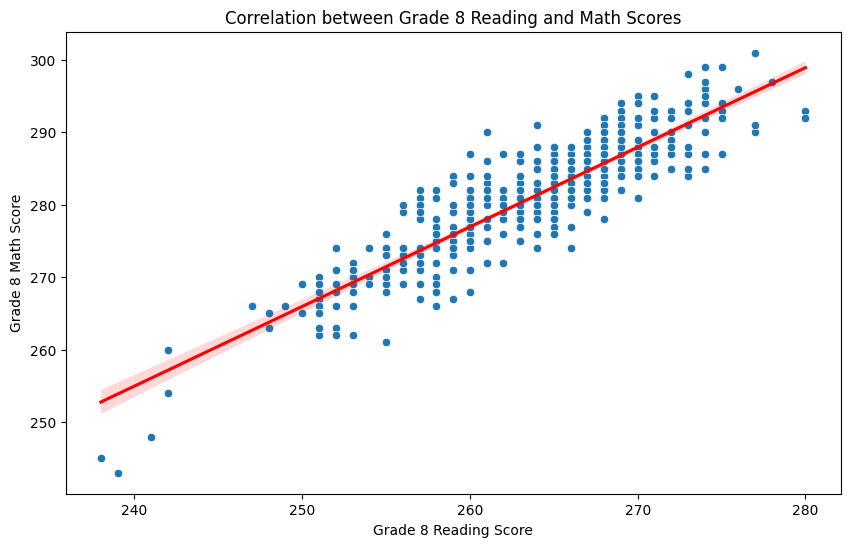

In [195]:

import seaborn as sns

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AVG_READING_8_SCORE', y='target', data=df)


# Add a trend line
sns.regplot(x='AVG_READING_8_SCORE', y='target', data=df, scatter=False, color='red')

# Add labels and title
plt.xlabel('Grade 8 Reading Score')
plt.ylabel('Grade 8 Math Score')
plt.title('Correlation between Grade 8 Reading and Math Scores')
# Show the plot
plt.show()

**Correlation between average 8th grade reading scores by state and average 8th grade math score**

**Visualization 2**

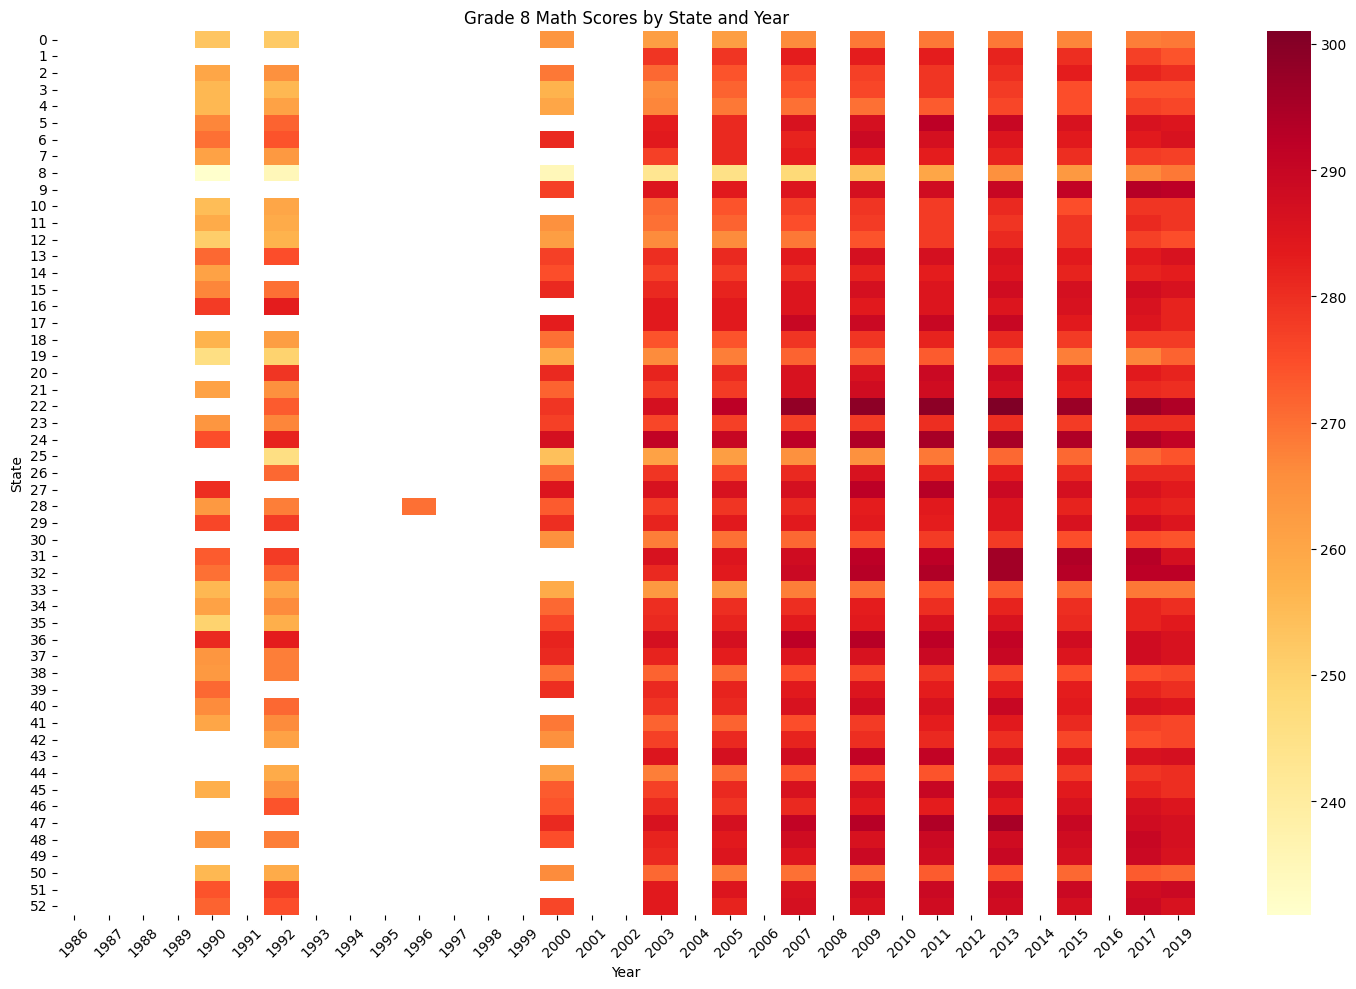

In [196]:
# Pivot the data to create a matrix of states, years, and scores
pivot_df = df.pivot(index='STATE', columns='YEAR', values='target')

# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_df, cmap='YlOrRd', annot=False)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('State')
plt.title('Grade 8 Math Scores by State and Year')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


**Heatmap relating state, year to average 8th grade math score**

<h2> Data Creation </h2>

_Use this space to create train/test data_

In [179]:
from sklearn.model_selection import train_test_split

In [180]:
df: pd.DataFrame = pd.read_csv("../data/states_edu.csv")
df = preprocess(df)
df_features, df_target = generate_features(df)

In [181]:
# X_train, X_test, y_train, y_test = train_test_split(
#      X, y, test_size=, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=42)
X, Y, index = clean_data(X_train, y_train)
XX, YY, _ = clean_data(X_test, y_test)

<h2> Prediction </h2>

ML Models [Resource](https://medium.com/@vijaya.beeravalli/comparison-of-machine-learning-classification-models-for-credit-card-default-data-c3cf805c9a5a)

In [182]:
# import your sklearn class here
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [183]:
# create your model here
# model = 
seed = 420
model_dict = {
    # 'lgb': LGBMRegressor(objective='regression_l1', n_estimators=300, random_state=42),
    # 'xgb': XGBRegressor(tree_method='hist', objective='reg:absoluteerror', n_estimators=300, random_state=42),
    'cbt': CatBoostRegressor(objective='MAE', iterations=1000, random_state=42),

}

In [184]:
def train(model, X, Y, index, N_fold: int = 5):
    for i in range(N_fold):
        model.fit(X[index%N_fold!=i], Y[index%N_fold!=i], 
                    eval_set=[(X[index%N_fold==i], Y[index%N_fold==i])],
                    )

In [185]:

for model in model_dict.values():
    train(model, X, Y, index)

0:	learn: 7.8047034	test: 7.6071419	best: 7.6071419 (0)	total: 22ms	remaining: 22s
1:	learn: 7.6538769	test: 7.4517327	best: 7.4517327 (1)	total: 35.9ms	remaining: 17.9s
2:	learn: 7.5112174	test: 7.3057573	best: 7.3057573 (2)	total: 50.6ms	remaining: 16.8s
3:	learn: 7.3553693	test: 7.1383417	best: 7.1383417 (3)	total: 64.5ms	remaining: 16.1s
4:	learn: 7.2213302	test: 7.0026953	best: 7.0026953 (4)	total: 83.6ms	remaining: 16.6s
5:	learn: 7.0831475	test: 6.8718977	best: 6.8718977 (5)	total: 99.8ms	remaining: 16.5s
6:	learn: 6.9624112	test: 6.7501792	best: 6.7501792 (6)	total: 113ms	remaining: 16.1s
7:	learn: 6.8261607	test: 6.6402106	best: 6.6402106 (7)	total: 125ms	remaining: 15.5s
8:	learn: 6.6988761	test: 6.5420715	best: 6.5420715 (8)	total: 147ms	remaining: 16.2s
9:	learn: 6.5652275	test: 6.4584370	best: 6.4584370 (9)	total: 160ms	remaining: 15.9s
10:	learn: 6.4486853	test: 6.3876164	best: 6.3876164 (10)	total: 175ms	remaining: 15.7s
11:	learn: 6.3461737	test: 6.3034300	best: 6.30343

In [186]:
def predict(model_dict, X_feat):
    return np.mean([model.predict(X_feat) for model in model_dict.values()], 0)

In [187]:
y_pred = predict(model_dict, XX)
y_pred

array([286.61198326, 283.53077096, 270.02463559, 265.42913075,
       288.05827942, 277.52559261, 289.39619751, 282.04884463,
       284.45903609, 277.8445789 , 284.30391088, 275.56548176,
       290.39167643, 269.99713771, 271.80466281, 278.9584686 ,
       285.86062548, 268.14726391, 286.43400371, 289.6571052 ,
       285.56334356, 287.09935455, 285.70261376, 279.46690602,
       283.90284722, 286.64216963, 269.9419333 , 279.62776429,
       264.66615156, 270.07975551, 273.44177982, 282.6865107 ,
       276.3711029 , 273.81173753, 274.82312994, 259.73243793,
       293.8334977 , 279.02404803, 287.69508756, 278.39434726,
       293.09748781, 278.82584942, 266.6645127 , 287.22269758,
       276.17317239, 284.38210396, 292.13856057, 270.58126746,
       269.64769881, 291.37570905, 285.18895108, 271.16096607,
       275.78585614, 285.36786836, 288.6307015 , 288.9259427 ,
       284.99971683, 284.48562166, 281.64828085, 268.06516188,
       287.65954993, 286.39857567, 271.64133492, 282.93

## Evaluation

Choose some metrics to evaluate the performance of your model, some of them are mentioned in the tutorial.

In [188]:
# Calculate baseline predictions (mean of Y)
y_baseline = np.full_like(YY, np.mean(Y))

# Calculate metrics for the model
mse_model = mean_squared_error(YY, y_pred)
mae_model = mean_absolute_error(YY, y_pred)
r2_model = r2_score(YY, y_pred)

# Calculate metrics for the baseline
mse_baseline = mean_squared_error(YY, y_baseline)
mae_baseline = mean_absolute_error(YY, y_baseline)
r2_baseline = r2_score(YY, y_baseline)

print("Model Performance:")
print(f"Mean Squared Error: {mse_model}")
print(f"Mean Absolute Error: {mae_model}")
print(f"R-squared Score: {r2_model}")

print("\nBaseline Performance:")
print(f"Mean Squared Error: {mse_baseline}")
print(f"Mean Absolute Error: {mae_baseline}")
print(f"R-squared Score: {r2_baseline}")


Model Performance:
Mean Squared Error: 17.50613688729913
Mean Absolute Error: 3.014907710562681
R-squared Score: 0.8128921389234358

Baseline Performance:
Mean Squared Error: 96.22125044936769
Mean Absolute Error: 8.012052495312915
R-squared Score: -0.02842520183624697


In [189]:
feature_importance = model.feature_importances_
sorted_features = sorted(zip(current_features, feature_importance), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

AVG_READING_8_SCORE: 36.544083037487084
YEAR: 4.778425476534603
ENROLL_ALL: 3.4148022245827057
SUPPORT_SERVICES_EXPENDITURE_TOTAL_REVENUE_REL: 2.8028459868464397
GRADE_8_TO_ALL_RATIO: 2.6699990921456633
STATE: 2.583982621602707
GRADE_8_TO_HS_RATIO: 1.7816308638884393
INSTRUCTION_EXPENDITURE_PER_STUDENT: 1.551232368249238
ENROLL_8: 1.5250127741758384
ENROLL_HS: 1.5045185505219072
LOCAL_REVENUE_TOTAL_EXPENDITURE_REL: 1.3008502868242862
TOTAL_REVENUE_FEDERAL_REVENUE_REL: 1.2932677954641696
OTHER_EXPENDITURE_LOCAL_REVENUE_REL: 1.290345286321323
TOTAL_REVENUE_PER_STUDENT: 1.2321933580042108
INSTRUCTION_EXPENDITURE_TOTAL_REVENUE_REL: 1.2155385063964852
OTHER_EXPENDITURE_TOTAL_REVENUE_REL: 1.2016900315645969
SUPPORT_SERVICES_EXPENDITURE_TOTAL_EXPENDITURE_REL: 1.160260089203411
FEDERAL_REVENUE_STATE_REVENUE_REL: 1.1461275874192811
FEDERAL_REVENUE_LOCAL_REVENUE_REL: 1.117366731382419
TOTAL_EXPENDITURE_TOTAL_REVENUE_REL: 1.1035537418218224
ENROLL_ALL_EST: 1.075002053629882
TOTAL_REVENUE_LOCAL_RE

We have copied over the graphs that visualize the model's performance on the training and testing set. 

Change `col_name` and modify the call to `plt.ylabel()` to isolate how a single predictor affects the model.

Text(0.5, 1.0, 'Model Behavior On Training Set')

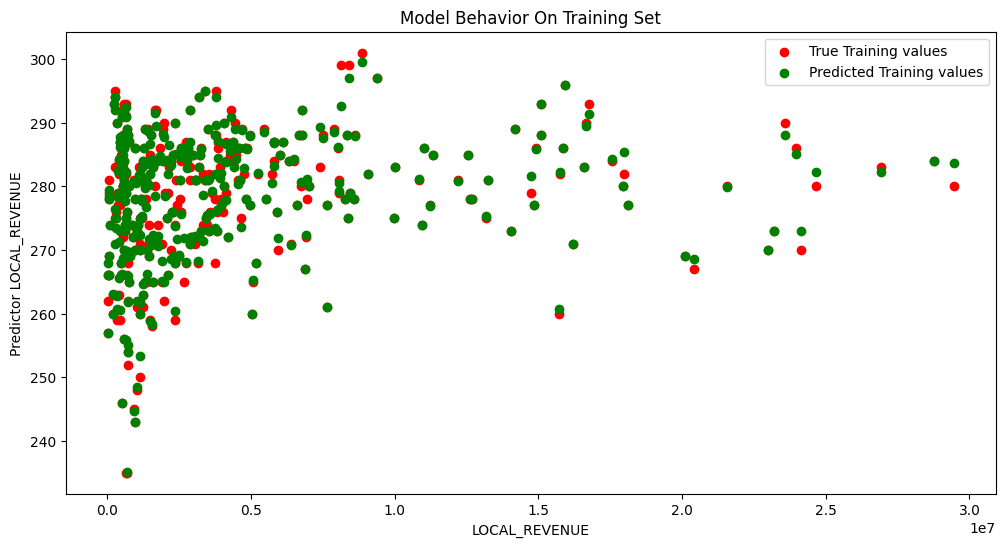

In [190]:

X_, Y_ = _clean_data(X_train, y_train)

predictor = 'LOCAL_REVENUE'

f = plt.figure(figsize=(12,6))
plt.scatter(X_[predictor], Y_, color = "red")
plt.scatter(X_[predictor], predict(model_dict, X), color = "green")

plt.legend(['True Training values','Predicted Training values'])
plt.xlabel(predictor)
plt.ylabel(f'Predictor {predictor}')
plt.title("Model Behavior On Training Set")

Text(0.5, 1.0, 'Model Behavior On Training Set')

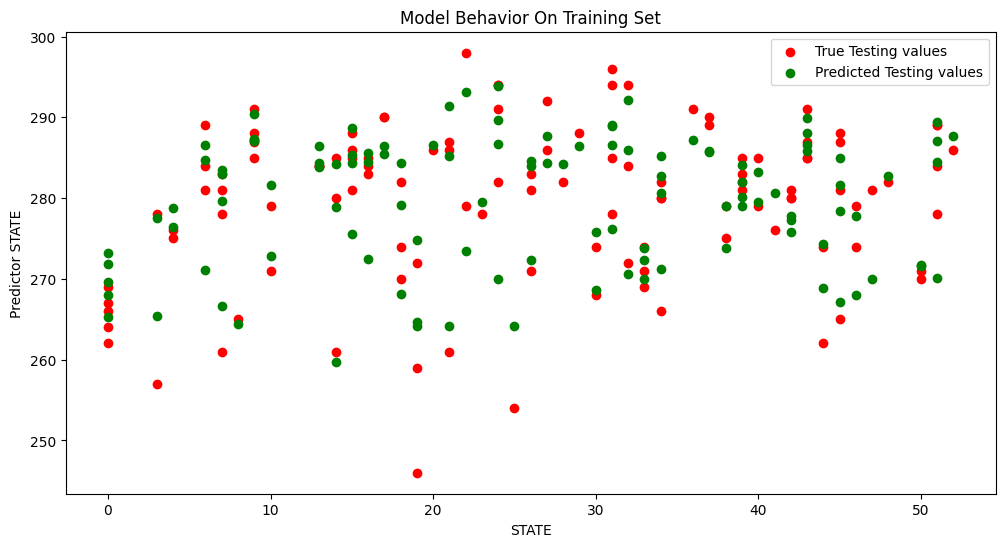

In [191]:

XX_, YY_ = _clean_data(X_test, y_test)

predictor = 'STATE'

f = plt.figure(figsize=(12,6))
plt.scatter(XX_[predictor], YY_, color = "red")
plt.scatter(XX_[predictor], predict(model_dict, XX), color = "green")

plt.legend(['True Testing values','Predicted Testing values'])
plt.xlabel(predictor)
plt.ylabel(f'Predictor {predictor}')
plt.title("Model Behavior On Training Set")